# RetinaMNIST

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- [ ]  Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- [ ] be sure that you understand the concept of an anchor for object detection, covered during Lecture 8. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits randomly selected from `MNIST` dataset on a canvas of size `(128, 128)`. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [1]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            str(self.class_nb),
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
           class_nb=class_nb,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        print(self.image.shape)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [2]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)

    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit = digits[current_digit_index]
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=classes[current_digit_index],
        ):
            attempts_done += 1
    return new_canvas

Let us have a look at example canvas:

(128, 128)


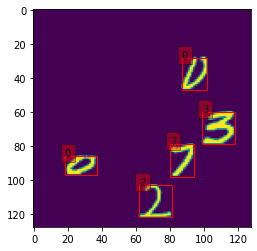

In [3]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

(128, 128)


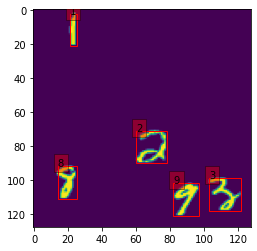

In [4]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (0.5pts)

For this task:
1. @DONE Sample at least 1000 random canvas.
2. @DONE Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

In [5]:
# TODO

widths = []
heighs = []
for i in range(1000):
  canvas =  get_random_canvas()
  #canvas.plot()
  for box in canvas.boxes:
    widths.append(box.x_diff)
    heighs.append(box.y_diff)

ANCHOR_SIZES = [16,19]

In [6]:
import numpy as np
from scipy.stats import mode
print(mode(widths))
print(mode(heighs))
print(np.mean(widths))
print(np.mean(heighs)) #todo z zajeć kmeans

ModeResult(mode=array([19]), count=array([4062]))
ModeResult(mode=array([19]), count=array([1146]))
18.712151616499444
14.80891861761427


In [7]:
np.histogram(heighs, bins=np.arange(21))

(array([   0,    0,    0,   38,   31,   89,   24,   49,   35,  155,   62,
         373,  152,  621,  176,  667,  176,  544,  147, 1146]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]))

$n in \{0,1, 32 -1}

### Model building (1pt)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

Backbone model should accept a `MnistCanvas` instance and output a tensor with shape $(1, \frac{128}{2^k}, \frac{128}{2^k}, filters)$ where $k \in {2, 3, 4}$ and $filters$ should be selected by student. We will later relate to selected $k$ as a stride. You can use a pretrained backbone.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 2^k, \left(n + \frac{1}{2}\right) * 2^k\right)$  for $m, n \in \{0, 1, \dots, \frac{128}{2^k} - 1\}$.

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{classificationHead}$:

$\texttt{classificationHead}$ should accept backbone output as an input and output `classification_output` tensor of shape $(len(\texttt{anchors)}, 10)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j$(ground truth box).

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$ where the value $br_{i}$ which is the value of i-th row has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$ 
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$ 
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$ 
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$ 

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

In [8]:
import torch.nn as nn

class NetConv(nn.Module):
    def __init__(self):
        super(NetConv, self).__init__()
        modules = []

        modules.append(nn.Conv2d(1, 16, 3, padding=1))
        modules.append(nn.BatchNorm2d(16))
        modules.append(nn.ReLU())
        modules.append(nn.MaxPool2d(2))

        modules.append(nn.Conv2d(16, 50, 3, padding=1))
        modules.append(nn.BatchNorm2d(50))
        modules.append(nn.ReLU())
        modules.append(nn.MaxPool2d(2))

        self.layers = nn.Sequential(*modules)

    def forward(self, x):
        x = self.layers(x)

        return x


In [9]:

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view((x.shape[0],) + self.shape)

class ClassificationHead(nn.Module):
    def __init__(self, anchors_number):
        super(ClassificationHead, self).__init__()
        modules = []
        modules.append(nn.Flatten())
        modules.append(nn.Linear(32*32*50, anchors_number*10))
        modules.append(Reshape(anchors_number,10))


        self.layers = nn.Sequential(*modules)

    def forward(self, x):
        x = self.layers(x)

        return x

In [10]:
class BoxRegressionHead(nn.Module):
    def __init__(self, anchors_number):
        super(BoxRegressionHead, self).__init__()
        modules = []
        modules.append(nn.Flatten())
        modules.append(nn.Linear(32*32*50, anchors_number*4))
        modules.append(Reshape(anchors_number, 4))
        self.layers = nn.Sequential(*modules)

    def forward(self, x):
        x = self.layers(x)

        return x

In [11]:
class DigitDetectionModelOutput:

    def __init__(
        self,
        anchors: List[MnistBox],
        classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.classification_output = classification_output
        self.box_regression_output = box_regression_output


class DigitDetectionModel(torch.nn.Module):
    # Should use ANCORS_SIZES
    anchors = []
    def __init__(
        self,
    ):
        for n in range(0, 128//4-1):
          for m in range(0, 128//4-1):
              self.anchors.append(MnistBox(m*4 - ANCHOR_SIZES[0]/2, n*4 - ANCHOR_SIZES[1]/2, m*4 + ANCHOR_SIZES[1]/2, n*4+ANCHOR_SIZES[0]/2))
        
        super().__init__()

        #backend
        self.backend = NetConv()
        
        #heads
        self.box_reg = BoxRegressionHead(anchors_number=len(self.anchors))
        self.classification = ClassificationHead(anchors_number=len(self.anchors))


    def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput: #dlaczego canvas a nie tensor? utrudnia robienie batchy
        #poprawka z canvasu na tensor
        x = x.get_torch_tensor()
        #backend
        x = self.backend(x)

        #heads
        box_regression_output = self.box_reg(x.permute(0,2,3,1))
        classification_output = self.classification(x.permute(0,2,3,1))



        return DigitDetectionModelOutput(self.anchors, classification_output, box_regression_output)



### Significant overlap (1pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `classification_target` - a tensor of shape $(len(anchors), 10)$,
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner: 

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$ 
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$ 
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$ 
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

and `classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{class_targets}[i, \texttt{gt_best.class_nb}] = 1.$$

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [12]:
class DigitDetectionModelTarget:

    def __init__(
        self,
        classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.classification_target = classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors

import torchvision

class TargetDecoder:

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.5,
        nb_of_classes: int = 10,
    ) -> DigitDetectionModelTarget:
        matched_anchors = []
        classification_target = torch.zeros([len(anchors), nb_of_classes])
        box_regression_target = torch.zeros([len(anchors), 4])
        for i in (range(len(anchors))):
          accept = []
          for box_a in canvas.boxes:
            if box_a.iou_with(anchors[i]) >= iou_threshold:
              accept.append({'box':box_a, 'iou': box_a.iou_with(anchors[i])})
              matched_anchors.append(i)
          #pobaramy indeks najlepszego iou
          if len(accept) > 0:
            naj_ind = 0
            for j in range(len(accept)):
                if accept[j]['iou'] > accept[naj_ind]['iou']:
                  naj_ind = j
            #anchor cos ma 
            classification_target[naj_ind, accept[naj_ind]['box'].class_nb] = 1
            box_regression_target[naj_ind, 0] = accept[naj_ind]['box'].x_min - anchors[i].x_min
            box_regression_target[naj_ind, 1] = accept[naj_ind]['box'].x_max - anchors[i].x_max
            box_regression_target[naj_ind, 2] = accept[naj_ind]['box'].y_min - anchors[i].y_min
            box_regression_target[naj_ind, 3] = accept[naj_ind]['box'].y_max - anchors[i].y_max


        return DigitDetectionModelTarget(classification_target, box_regression_target, matched_anchors)


                        

    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
        scores = torch.zeros(len(model_output.anchors)).to(DEVICE)
        boxes = torch.zeros([len(model_output.anchors), 4]).to(DEVICE)
        scores,_ = torch.max(model_output.classification_output[0], dim=1)
        print(scores.shape)
        exit(-1)
        for i in range(len(model_output.anchors)):
          boxes[i,0] = model_output.anchors[i].x_min - model_output.box_regression_output[0][i][0]
          boxes[i,1] = model_output.anchors[i].y_min - model_output.box_regression_output[0][i][2]
          boxes[i,2] = model_output.anchors[i].x_max - model_output.box_regression_output[0][i][1]
          boxes[i,3] = model_output.anchors[i].y_max - model_output.box_regression_output[0][i][3]

        indexes = torchvision.ops.nms(boxes, scores, 0.5)
        out_list = []
        for index in indexes:
          out_list.append(MnistBox(x_min=boxes[index,0],x_max =boxes[index,2],y_min=boxes[index,1], y_max=boxes[index,3], class_nb=torch.argmax(model_output.classification_output[0][index])))

        return out_list


### Metrics (0.5pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`: 

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between classes predictions and targets averaged only over matched anchors.

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [13]:
import torch
import torchvision 
from torch.nn import SmoothL1Loss
from torchvision.ops import sigmoid_focal_loss 

class RetinaLoss:

    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]: 
        loss_box_regression = 0
        loss_classification = 0 
        #for anchor_index in model_target.matched_anchors: @TODO do zmiany na wielu batch.
        test = SmoothL1Loss()
        loss_box_regression += test(model_output.box_regression_output[0].to(DEVICE), model_target.box_regression_target.to(DEVICE))
        loss_classification += sigmoid_focal_loss(model_output.classification_output[0].to(DEVICE), model_target.classification_target.to(DEVICE), reduction='mean') 

        if len(model_target.matched_anchors) == 0:
          return None

        return (loss_box_regression + loss_classification)* model_output.classification_output.shape[1] / len(model_target.matched_anchors)


class DigitAccuracy:

    def compute_metric(
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
        for box in canvas.boxes:
          find = False
          #bijection
          for pbox in predicted_boxes:
            if box.iou_with(pbox) > 0.5 and box.class_nb == pbox.class_nb:
              if find: #not injection
                return 0
              find = True
        if len(canvas.boxes) == len(predicted_boxes):
          return 1
        # not bijection
        return 0

              

In [14]:

import torch.optim as optim

def train():
        model = DigitDetectionModel()
        model.to(DEVICE)

        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        rloss = RetinaLoss()
        acc = DigitAccuracy()
        target = TargetDecoder()
        
        acc_add = 0

        for epoch in range(100):
            canvas = get_random_canvas()
            #canvas_tensor = canvas.get_torch_tensor()
            #canvas_tensor = canvas_tensor.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(canvas)
            acc_value = acc.compute_metric(target.get_predictions(outputs), canvas)

            targets = target.get_targets(canvas, outputs.anchors, iou_threshold=0.5, nb_of_classes=10)
            loss = rloss.compute_loss(outputs, targets)

            print('treningowe accuracy:', acc)
            print('loss', loss)
            loss.backward()
            print("ayay")
            optimizer.step()
            print("no tu nas raczej nie bedzie")
            acc_add+=acc_value
            
                    

            print('Accuracy of the network on the {} test images: {} %'.format(
                1, acc_add))

In [15]:
train()

torch.Size([961])
treningowe accuracy: <__main__.DigitAccuracy object at 0x7fc89efdee10>
loss tensor(24.6750, device='cuda:0', grad_fn=<DivBackward0>)
ayay
no tu nas raczej nie bedzie
Accuracy of the network on the 1 test images: 0 %
torch.Size([961])
treningowe accuracy: <__main__.DigitAccuracy object at 0x7fc89efdee10>
loss tensor(16.6964, device='cuda:0', grad_fn=<DivBackward0>)
ayay
no tu nas raczej nie bedzie
Accuracy of the network on the 1 test images: 0 %
torch.Size([961])
treningowe accuracy: <__main__.DigitAccuracy object at 0x7fc89efdee10>
loss tensor(14.9830, device='cuda:0', grad_fn=<DivBackward0>)
ayay
no tu nas raczej nie bedzie
Accuracy of the network on the 1 test images: 0 %
torch.Size([961])
treningowe accuracy: <__main__.DigitAccuracy object at 0x7fc89efdee10>
loss tensor(26.5060, device='cuda:0', grad_fn=<DivBackward0>)
ayay
no tu nas raczej nie bedzie
Accuracy of the network on the 1 test images: 0 %
torch.Size([961])
treningowe accuracy: <__main__.DigitAccuracy o

### Train your model (1pt)

One should use all classes defined above to train the model.

A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

Plot example results of matched and mismatched predictions (0.5pt).

_Hint:_ note that all classes defined above accept only a single canvas as their inputs. Can we extend a training loop to use it for a training on batches?

Have fun!